# Background

Author: Diane Menuz
Date: 8/25/2025

Purpose: Compare ET data between weather station and openet, based on static footprint data

Attributes in the output of the flux_data_qaqc routine are described here:  
https://flux-data-qaqc.readthedocs.io/en/latest/tutorial.html. The ET value has ET calculated  
from input LE and average air temperature and may be missing some dates. The ET_corr variable  
has ET calculated from LE_corr and may be gap-filled. The ET_gap field indicates which dates are  
gap-filled

Cedar Mesa had 28 gap-filled days out of 601 days.

# Data Imports and Cleanup

In [1]:
import os
import pandas as pd

In [2]:
base_folder = r'M:\Shared drives\UGS_Flux\Data_Processing\Footprint'
landsat_dates = os.path.join(base_folder, 'landsat_overpass_dates\\US-CdM_landsat_ard_tile.csv')
openet_eto = os.path.join(base_folder, 'openet_data\\openet_cedarmesa_eto_static.csv')
openet_base = os.path.join(base_folder, 'openet_data\\openet_cedarmesa02_footprint.csv')

dat_folder = r'M:\Shared drives\UGS_Flux\Data_Processing\config\output'
daily_dat = 'US-CdM_daily_data.csv'
monthly_dat = 'US-CdM_monthly_data.csv' 

In [4]:
# read in files
ebr_filled = pd.read_csv(os.path.join(dat_folder, daily_dat), parse_dates=['date'])
openet = pd.read_csv(openet_base, parse_dates=['time'])
landsat = pd.read_csv(landsat_dates, encoding='latin1', parse_dates=['Acquisition Date'])
landsat_sub = landsat[[ 'Acquisition Date', 'Spacecraft Identifier', 'Sensor Identifier','Cloud Cover', 'Cloud Shadow', 'Snow Ice', 'Fill (No Data)' ]]
landsat_sub['landsat_overpass']=True

C:\Users\dmenuz\AppData\Local\Temp\1\ipykernel_26380\3921810235.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landsat_sub['landsat_overpass']=True


In [5]:
# review ebr data
ebr_filled.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 601 entries, 0 to 600
Data columns (total 48 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            601 non-null    datetime64[ns]
 1   t_avg           581 non-null    float64       
 2   vpd             569 non-null    float64       
 3   t_dew           569 non-null    float64       
 4   Rn              581 non-null    float64       
 5   vp              572 non-null    float64       
 6   wd              581 non-null    float64       
 7   lw_out          576 non-null    float64       
 8   rh              571 non-null    float64       
 9   sw_out          567 non-null    float64       
 10  sw_in           520 non-null    float64       
 11  ws              581 non-null    float64       
 12  H               573 non-null    float64       
 13  es              581 non-null    float64       
 14  LE              573 non-null    float64       
 15  theta_

In [6]:
ebr_merge = pd.merge(ebr_filled, openet, left_on='date', right_on='time')
ebr_final = pd.merge(ebr_merge, landsat_sub, left_on='date',right_on='Acquisition Date', how='left')
ebr_final.set_index('date', inplace=True)
print(ebr_final[['ET', 'ET_corr', 'DisALEXI', 'Ensemble', 'PTJPL','SSEBop', 'eeMETRIC', 'geeSEBAL', 'landsat_overpass']].head())

                  ET   ET_corr  DisALEXI  Ensemble  PTJPL  SSEBop  eeMETRIC  \
date                                                                          
2024-01-01  0.143167  0.134944     0.521     0.326  0.451   0.210     0.333   
2024-01-02  0.159903  0.152245     0.299     0.188  0.263   0.121     0.192   
2024-01-03  0.181931  0.156111     0.395     0.250  0.355   0.160     0.255   
2024-01-04  0.280702  0.300151     0.352     0.225  0.322   0.143     0.228   
2024-01-05  0.257500  0.275341     0.564     0.362  0.525   0.229     0.366   

            geeSEBAL landsat_overpass  
date                                   
2024-01-01     0.000             True  
2024-01-02     0.011             True  
2024-01-03     0.029              NaN  
2024-01-04     0.039              NaN  
2024-01-05     0.084              NaN  


# Data Comparison

In [7]:
micromet_path= "C:/Users/dmenuz/Documents/scripts/MicroMet/src/micromet"
loggerloader_path= "C:/Users/dmenuz/Documents/scripts/loggerloader"
eddy_plots = 'C:/Users/dmenuz/Documents/scripts/eddy/functions'


In [8]:
import pandas as pd
import numpy as np

import importlib.util
from sqlalchemy import create_engine, inspect
from urllib.parse import quote  
import requests
import json

import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from scipy.stats import linregress
import statsmodels.api as sm

import plotly.io as pio
pio.renderers.default = 'notebook' 

In [9]:
# import functions
import sys
sys.path.append(micromet_path)
import graphs as mm_graphs

sys.path.append(loggerloader_path)
import loggerloader as ll

sys.path.append(eddy_plots)
import eddy_plots as ed_plot

In [10]:
ebr_final.columns

Index(['t_avg', 'vpd', 't_dew', 'Rn', 'vp', 'wd', 'lw_out', 'rh', 'sw_out',
       'sw_in', 'ws', 'H', 'es', 'LE', 'theta_2', 'G', 'theta_mean', 'theta_1',
       'lw_in', 't_min', 't_max', 'Rn_subday_gaps', 'H_subday_gaps',
       'G_subday_gaps', 'ppt', 'LE_subday_gaps', 'rso', 'flux', 'energy',
       'flux_corr', 'ebr', 'ebr_5day_clim', 'ebc_cf', 'ebr_corr', 'LE_corr',
       'DOY', 'H_corr', 'ET', 'ET_corr', 'gridMET_ETr', 'gridMET_ETo',
       'gridMET_prcp', 'ETrF', 'ETrF_filtered', 'ET_fill', 'ET_gap',
       'ET_fill_val', 'time', 'DisALEXI', 'Ensemble', 'PTJPL', 'SSEBop',
       'eeMETRIC', 'geeSEBAL', 'Acquisition Date', 'Spacecraft Identifier',
       'Sensor Identifier', 'Cloud Cover', 'Cloud Shadow', 'Snow Ice',
       'Fill (No Data)', 'landsat_overpass'],
      dtype='object')

In [17]:
# The list of satellite models you want to evaluate against the ground-based 'ET' data.
vars = ['ET', 'DisALEXI', 'Ensemble', 'PTJPL', 'SSEBop', 'eeMETRIC', 'geeSEBAL']

regression_results = []

for var in vars:
    # Create a temporary DataFrame with only the ground-based and satellite data, dropping any rows with missing values.
    temp_df = ebr_final[['ET_corr', var]].dropna()
    
    # Separate the data into ground-based (x) and satellite (y) values
    ground_data = temp_df['ET_corr'].values
    satellite_data = temp_df[var].values
    
    # Calculate the direct differences between the two datasets
    differences = satellite_data - ground_data
    
    # --- Calculate error metrics based on direct differences ---
    # Mean Bias Error (MBE): Measures the average bias (over/underestimation).
    mbe = np.mean(differences)
    # Mean Absolute Error (MAE): Quantifies the average absolute difference.
    mae = np.mean(np.abs(differences))
    # Root Mean Squared Error (RMSE): Gives more weight to larger errors.
    rmse = np.sqrt(np.mean(differences**2))
    
    # --- Calculate percentage error metrics ---
    # Calculate the mean of the ground-based data, used as the normalization factor.
    ground_mean = np.mean(ground_data)
    # Percent Mean Bias Error (PMBE): MBE as a percentage of the ground data mean.
    pmbe = (mbe / ground_mean) * 100    
    # Mean Absolute Percentage Error (MAPE): MAE as a percentage of the ground data mean.
    mape = (mae / ground_mean) * 100    
    # Root Mean Squared Percentage Error (RMSPE): RMSE as a percentage of the ground data mean.
    rmspe = (rmse / ground_mean) * 100
    
    # --- Calculate regression metrics ---
    # Perform linear regression to get the slope, intercept, and R-squared.
    slope, intercept, r_value, p_value, std_err = linregress(ground_data, satellite_data)
    
    # --- Append all results to the results list ---
    regression_results.append({
        'Model': var,
        'N': len(ground_data),
        'R-squared': r_value**2,
        'Slope': slope,
        'MBE': mbe,
        'MAE': mae,
        'RMSE': rmse,
        'PMBE (%)': pmbe,
        'MAPE (%)': mape,
        'RMSPE (%)': rmspe
    })

# Convert the list of results dictionaries into a pandas DataFrame
results_df = pd.DataFrame(regression_results)

# Print the final DataFrame, rounded to 2 decimal places for better readability
print(results_df.round(2))

      Model    N  R-squared  Slope   MBE   MAE  RMSE  PMBE (%)  MAPE (%)  \
0        ET  557       0.98   0.98  0.01  0.06  0.08      1.35      8.64   
1  DisALEXI  584       0.03   0.16  0.16  0.54  0.80     24.22     80.12   
2  Ensemble  584       0.03   0.13  0.02  0.46  0.69      3.68     68.17   
3     PTJPL  584       0.17   0.30  0.30  0.53  0.67     45.55     79.54   
4    SSEBop  584       0.08   0.26  0.21  0.56  0.74     31.07     84.15   
5  eeMETRIC  584       0.00   0.04 -0.49  0.59  0.88    -73.05     87.82   
6  geeSEBAL  584       0.00   0.03 -0.18  0.64  0.93    -26.62     96.21   

   RMSPE (%)  
0      12.16  
1     118.94  
2     102.68  
3      99.67  
4     109.77  
5     131.63  
6     138.64  


NameError: name 'save_fig_name' is not defined

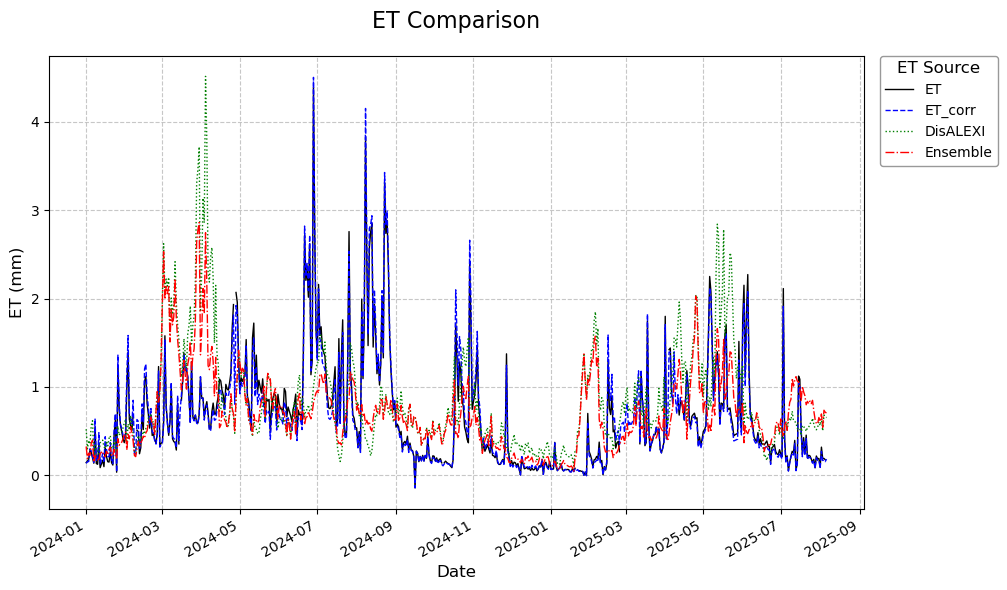

In [11]:
df = ebr_final.copy()
cols=['ET','ET_corr','DisALEXI', 'Ensemble']#, 'PTJPL','SSEBop', 'eeMETRIC', 'geeSEBAL']
title = 'ET Comparison'
#save_fig_name = f'et_timeseries_{stationid}_2024.png'

# time series plot


%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 6)) 

ax.plot(df.index, df[cols[0]] , label=f'{cols[0]}', 
        color='black', linestyle='-', linewidth=1)
ax.plot(df.index, df[cols[1]] , label=f'{cols[1]}', 
        color='blue', linestyle='--', linewidth=1)
ax.plot(df.index, df[cols[2]] , label=f'{cols[2]}', 
        color='green', linestyle=':', linewidth=1)
ax.plot(df.index, df[cols[3]] , label=f'{cols[3]}', 
        color='red', linestyle='-.', linewidth=1)


ax.set_title(title, fontsize=16, pad=20) 
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('ET (mm)', fontsize=12)

# Customize the legend
ax.legend(
    loc='upper left',       
    bbox_to_anchor=(1.02, 1),
    borderaxespad=0.,     
    title='ET Source',    
    fontsize=10,         
    title_fontsize=12,   
    frameon=True,        
    edgecolor='gray',    
    facecolor='white',   
    shadow=False         
)


fig.autofmt_xdate() 

ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.savefig(save_fig_name)

plt.show()
plt.close() 

In [ ]:
import plotly.graph_objects as go
import pandas as pd

df = ebr_final.copy()
cols=['ET','ET_corr','DisALEXI', 'Ensemble']#, 'PTJPL','SSEBop', 'eeMETRIC', 'geeSEBAL']
title = 'ET Comparison'

# Create a figure
fig = go.Figure()

# Add a trace for each column
fig.add_trace(go.Scatter(x=df.index, y=df['ET'], mode='lines', name='ET', 
                         line=dict(color='black', dash='solid', width=1)))
fig.add_trace(go.Scatter(x=df.index, y=df['ET_corr'], mode='lines', name='ET_corr', 
                         line=dict(color='blue', dash='dash', width=1)))
fig.add_trace(go.Scatter(x=df.index, y=df['DisALEXI'], mode='lines', name='DisALEXI', 
                         line=dict(color='green', dash='dot', width=1)))
fig.add_trace(go.Scatter(x=df.index, y=df['Ensemble'], mode='lines', name='Ensemble', 
                         line=dict(color='red', dash='dashdot', width=1)))


# Customize the layout
fig.update_layout(
    title='ET Comparison',
    xaxis_title='Date',
    yaxis_title='ET (mm)',
    xaxis=dict(gridcolor='rgba(128,128,128,0.2)'),
    yaxis=dict(gridcolor='rgba(128,128,128,0.2)'),
    legend=dict(
        title_text='ET Source',
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="right",
        x=1.1,
        bgcolor='white',
        bordercolor='gray',
        borderwidth=1
    )
)

# Display the plot
fig.show()

# To save the plot to a file, uncomment the following line
# fig.write_html('et_timeseries.html')

In [ ]:
## ols plots 
%matplotlib inline

for var in vars[2:]:
    plt.figure()  
    temp_df = ebr_final[['ET', var]].dropna()
    ed_plot.ols_plot(temp_df['ET'], temp_df[var], 
        xlabel=f'Daily ET (mm) from Station', 
        ylabel=f'Daily ET (mm) from OpenET {var}', 
        title= f'Daily ET Comparison')
    plt.tight_layout()  
    #plt.savefig(f'ols_{stationid}_{var}.png')
    plt.show()
    plt.close()

In [ ]:
## bland-altman
for var in vars:
    print(f'Bland-Altman plot for {var}')
    plt.figure()  
    f, ax = plt.subplots(1, figsize = (8,3.5))
    sm.graphics.mean_diff_plot(ebr_final['ET'], ebr_final[var], ax = ax)
    plt.tight_layout()  
    #plt.savefig(f'ba_{stationid}_{var}.png')
    plt.show()
    plt.close() 

In [ ]:
monthly = et_merge.resample('ME').sum()

In [ ]:
# monthlyscatter plots color-coded by data quality
monthly_plot = monthly.reset_index() # This turns the index into a column named 'index' by default
monthly_plot = monthly_plot.rename(columns={'index': 'date'})
monthly_plot['month_label'] = monthly_plot['date'].dt.month 



for var in vars:
    fig = px.scatter(
        data_frame=monthly_plot,
        x='ET',       
        y=f'{var}',       
        title=f'Monthly ET vs. {var}',
        text='month_label'
    )
    fig.update_traces(textposition='top right')
    fig.update_layout(
        width=800,
        height=400 
        )

    min_val = min(monthly_plot['ET'].min(), monthly_plot[f'{var}'].min())
    max_val = max(monthly_plot['ET'].max(), monthly_plot[f'{var}'].max())
    padding = (max_val - min_val) * 0.05
    min_val -= padding
    max_val += padding
    line_coords = np.linspace(min_val, max_val, 100)

    fig.add_trace(
        go.Scatter(
            x=line_coords,
            y=line_coords,
            mode='lines',
            showlegend=False,
            line=dict(color='black', dash='dot', width=1.5), 
            hoverinfo='skip' 
        )
    )

    fig.show()